# PCA / SVD / LDA FUNDAMENTALS
  
  Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. SVD is a component of PCA that can be used in feature reduction, but I've had a hard time finding and SVD analysis without PC analysis.

Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance _**between classes**_. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.
  
  For any analysis below, start by summarizing and examining the data
  

In [145]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

# read into pandas
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

# what do we know about the data?
print('dimensions: ',df.shape,'\n')
print('data head: \n',df.head(5),'\n')
print('summary stats: \n',df.describe(),'\n')

# may want to check for imbalanced classes
print('class sizes: \n',df.groupby('target').size(),'\n')

dimensions:  (150, 5) 

data head: 
    sepal length  sepal width  petal length  petal width       target
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa 

summary stats: 
        sepal length  sepal width  petal length  petal width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000    

The effects of not scaling with PCA and other techniques can be really problematic! See:
http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py  
  
Seperating and scaling features from target:

In [146]:
from sklearn.preprocessing import StandardScaler

features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# remove features from df
x = df.loc[:, features].values
# specify the target
y = df.loc[:,['target']].values
# standardize features
# Standard scaler applies unit scale to each feature (mean = 0, variance = 1)
x = StandardScaler().fit_transform(x)

# PCA: PRINCIPAL COMPONENTS ANALYSIS

2. Generate the components

In [129]:
from sklearn.decomposition import PCA
# specify how many components. You can do more without penalty, but think about what you're using them for..
# if you save more PCs, make sure to change the column names below to allow for more columns!
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,columns = ['principal component 1','principal component 2'])
# combine with categories
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

3. Visualize along new axes (eigenvectors)

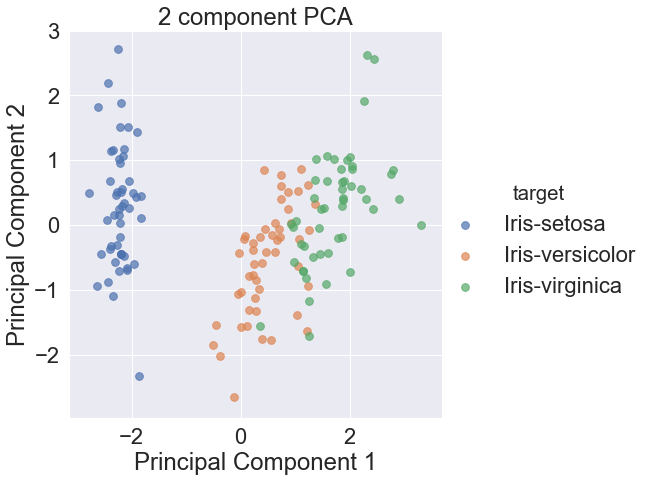

In [130]:
import matplotlib.pyplot as plt

## pyplot
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)

# targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
# colors = ['r', 'g', 'b']
# for target, color in zip(targets,colors):
#     indicesToKeep = finalDf['target'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#                , finalDf.loc[indicesToKeep, 'principal component 2']
#                , c = color
#                , s = 50)
# ax.legend(targets)
# ax.grid()

sns.set(font_scale=2) 
g = sns.lmplot('principal component 1', 'principal component 2', finalDf, hue='target', fit_reg=False, height=7
              ,scatter_kws={'alpha':0.7,'s':60})
g.set(xlabel='Principal Component 1', ylabel='Principal Component 2',title='2 component PCA')


4. Describe how much variance is explained by your principal components

In [131]:
print('PC1 \t PC2\n',pca.explained_variance_ratio_)

PC1 	 PC2
 [0.72770452 0.23030523]


Eigenvalue decomposition and Singular value decomposition from linear algebra are the two main procedures used in PCA.  
  
  Eigenvalue decomposition is a matrix factorization algorithm applicable to semi-definite matrix. In the context of PCA, an eigenvector represents a direction or axis and the corresponding eigenvalue represents variance along that eigenvector. Higher the eigenvalue, higher will be the variance along that eigenvector.  
  
  SVD is a matrix factorization method which expresses a matrix as a linear combination of rank 1 matrices. SVD is more stable than PCA and it doesn't require a positive definite matrix.  
  
  Each singular value is the square-root of the corresponding eigenvalue.
  
![](https://s3-us-west-2.amazonaws.com/articles-dimred/pca/svd.png "Logo Title Text 1")

  
  sources: 
  https://blog.paperspace.com/dimension-reduction-with-principal-component-analysis/  
  https://blog.applied.ai/feature-reduction-using-svd/

# FEATURE REDUCTION USING SVD

1. Generate matrices and PCs

In [132]:
from scipy.sparse.linalg import svds
import numpy as np

# use scaled features data only ('x'), we've already done that (above)
# make matrices
u, s, vt = svds(x,2)
# make PCs
pc = u @ np.diag(s)
pc = pc[:,::-1]

2. Calculate variance explained (cumulative)

In [134]:
explained_variance = np.var(pc, axis=0)
full_variance = np.var(x, axis=0)
explained_variance_ratio = explained_variance / full_variance.sum()
explained_variance_ratio.cumsum()

array([0.72770452, 0.95800975])

3. Visualize. Note it's essentially the same as PCA

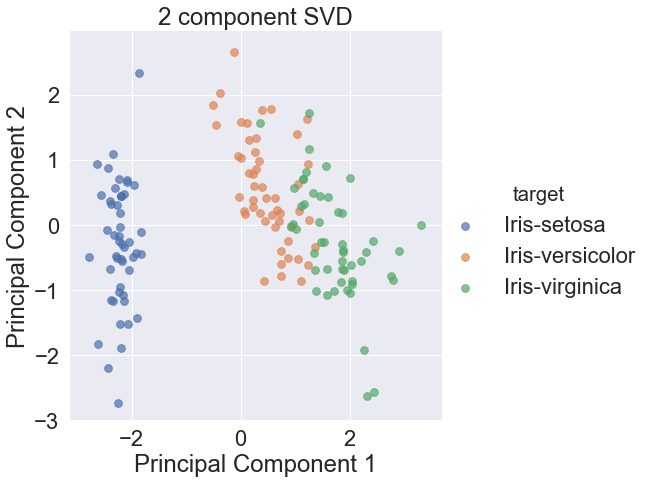

In [136]:
svd_df = pd.DataFrame(pc,columns=('c0','c1'))
iris_svd = pd.concat([svd_df, df[['target']]], axis = 1)

sns.set(font_scale=2) 
g = sns.lmplot('c0', 'c1', iris_svd, hue='target', fit_reg=False, height=7
              ,scatter_kws={'alpha':0.7,'s':60})
g.set(xlabel='Principal Component 1', ylabel='Principal Component 2',title='2 component SVD')


# LDA: LINEAR DISCRIMINANT ANALYSIS

1. Generate LDs

In [71]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# again number of components doesn't really matter
lda = LinearDiscriminantAnalysis(n_components=2)
## ravel makes sure column-formatted data is in correct format (array)
LDs = lda.fit(x, y.ravel()).transform(x)
LDsDf = pd.DataFrame(data = LDs,columns = ['LDA 1','LDA 2'])
# combine with categories
finalDf_LDA = pd.concat([LDsDf, df[['target']]], axis = 1)

2. Visualize along new axes. Note that seperation between versicolor and virginica is better!

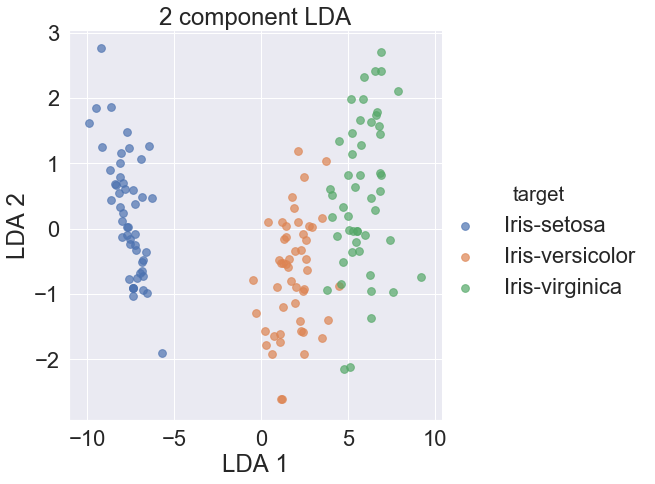

In [138]:
sns.set(font_scale=2) 
g = sns.lmplot('LDA 1', 'LDA 2', finalDf_LDA, hue='target', fit_reg=False, height=7
              ,scatter_kws={'alpha':0.7,'s':60})
g.set(xlabel='LDA 1', ylabel='LDA 2',title='2 component LDA')

# K NEAREST NEIGHBORS 

While PCA/LDA helps cluster data according to variance and reduces dimensionality, we need a different algorithm to predict new data.  
  
  Normalization is also important for Kmeans to select the appropriate neighbors. See: https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn
  
1. Numerically encode categories, since KNN can't handle strings 

In [147]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

/Users/avahoffman/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2. Split train-test and load modules

In [152]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

3. Remember that choosing K for number of neighbors to use for classification is NOT trivial. Test across values of K using cross-validation.

In [153]:
k_list = list(range(1,50,2))
# creating list of cv scores
cv_scores = []

# perform 10-fold cross validation
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

# best k will minimize MSE (error)
best_k = k_list[MSE.index(min(MSE))]

print(best_k)


7


4. Visualizing error across many k (optional)

<Figure size 432x288 with 0 Axes>

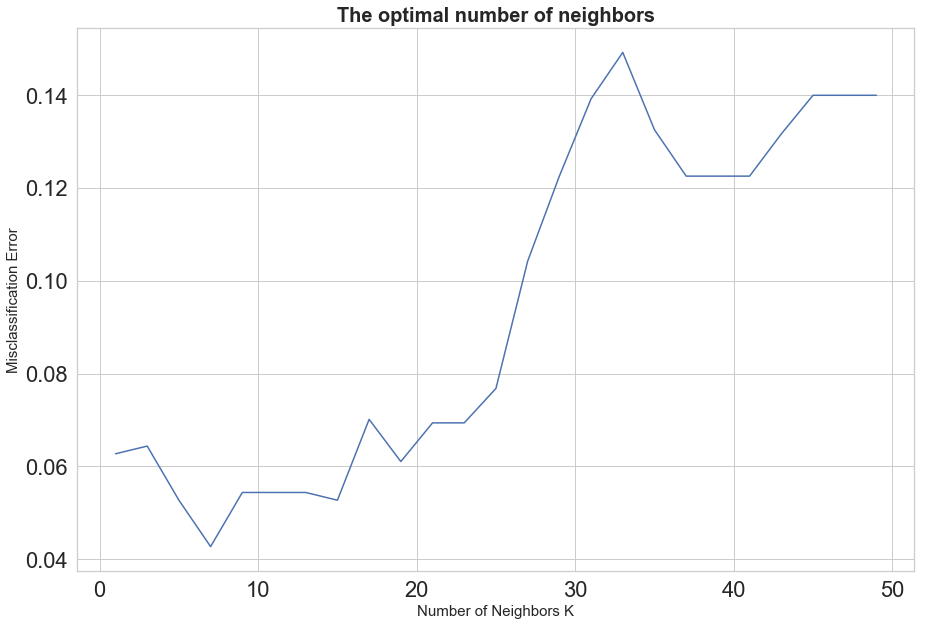

In [154]:
import seaborn as sns

plt.figure()
plt.figure(figsize=(15,10))
plt.title('The optimal number of neighbors', fontsize=20, fontweight='bold')
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Misclassification Error', fontsize=15)
sns.set_style("whitegrid")
plt.plot(k_list, MSE)

plt.show()

5. Train KNN classifier using best k above. Play around with different K to see how it affects the CM and accuracy

In [155]:
classifier = KNeighborsClassifier(n_neighbors=best_k)

# Fitting the model
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred)*100)

[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]
97.36842105263158
